# Capsone Project-- DNN based speaker verification system 

Zhihong Zhang

This Capstone project is to implement the CNN structure to d

The work can be mainly seperated into three part, preprocessing, modeling and the improvement. 

For the preprocessing part. This part is to preprocess audio data, and change it into numpy form based on the fast Fourier Transform.

# Set up

For this project, I would like to mainly use pytorch to deal with the model for its simplicity and debugging part. 

After setting up, the code will be seperated into following section  
1. Research code:  the LightningModule

2.  Engineering code: Trainer

3. Non-essential : Callbacks

4. Data: LightningDataModule


In [ ]:
#for transform 
#!pip install torchvision

tf example: https://www.kaggle.com/beastlyprime/tensorflow-speaker-verification 

In [1]:
#for model work properly
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split



In [2]:
#set up tensorboard
# Call flush() method to make sure that all pending events have been written to disk.
#import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
!pip install tensorboard

Also, we set up tensorboard for late tuning the hyperparameter

Here we can check our computing device

In [ ]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
## use for the version control 
#! ls lighting_logs/version_6/checkpoints

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

plp code:
https://github.com/mystlee/rasta_py/blob/master/rasta.py

In [6]:
#install torch audio
!pip install torchaudio

In [7]:
import torchaudio
import requests
import matplotlib.pyplot as plt

## Download data

In this version, I will use Librispeech dataset only for its ease accessibility. Since dataset is large,

In [ ]:
#import torchaudio
#use train clean 100 for train, technically can use other form
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)


Or, I can copy data from google drive

In [ ]:
!ls
!pwd

drive  runs  sample_data
/content


In [ ]:
# The way to export data to local instance
#extract data to colab
#import shutil
#shutil.unpack_archive("/content/drive/MyDrive/libri/test-clean.tar.gz", "/content/")
#shutil.unpack_archive("/content/drive/MyDrive/libri/train-clean-100.tar.gz", "/content/")
#shutil.unpack_archive("/content/drive/MyDrive/libri/dev-clean.tar.gz", "/content/")

For convenience we directly get file from the gdrive

In [ ]:
## also slow on copy from google drive to instance 
!cd "drive/MyDrive/libri/"
%cp -av "/content/drive/MyDrive/libri/test-clean.tar.gz" "/content/"
%cp -av "/content/drive/MyDrive/libri/train-clean-100.tar.gz" "/content/"

'/content/drive/MyDrive/libri/test-clean.tar.gz' -> '/content/test-clean.tar.gz'
'/content/drive/MyDrive/libri/train-clean-100.tar.gz' -> '/content/train-clean-100.tar.gz'


In [ ]:
#import dataset without download big data
#use train clean 100 for train, technically can use other form
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=False)

In [ ]:
!pip install pydub

In [ ]:
#set up file path
train_path = "/content/drive/MyDrive/LibriSpeech/train-clean-100/"
test_path  = "/content/drive/MyDrive/LibriSpeech/test-clean/"
dev_path   = "/content/drive/MyDrive/LibriSpeech/dev-clean/"

In [ ]:
#Here I tried to convert form and used old method to finish the part. 

import pydub
import os
import tqdm
import glob
class Flac2Wav:
  def flac2wav(filepath):
    base_file_path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    filename_no_ext = os.path.splitext(filename)[0]
    audio = AudioSegment.from_file(filepath, "flac")
    wav_file_path = base_file_path + '/' + filename_no_ext +'.wav'
    audio.export(wav_file_path, format="wav")
 
  def convert_flac_to_wav(train_path, dev_path, test_path):
    train_flac = [file for file in glob.glob(train_path + "/*/*/*.flac")]
    dev_flac = [file for file in glob.glob(dev_path + "/*/*/*.flac")]
    test_flac = [file for file in glob.glob(test_path + "/*/*/*.flac")]
   
    print("Converting %d train %d dev and %d test flac files into wav files"
          % (len(train_flac), len(dev_flac), len(test_flac)))   
   
    print("Processing train")
    for f in tqdm(train_flac):
        flac2wav(f)
   
    print("Processing dev")
    for f in tqdm(dev_flac):
        flac2wav(f)
       
    print("Processing test")
    for f in tqdm(test_flac):
        flac2wav(f)
  



if __name__ == "__main__":
    Flac2Wav()



  

## Format convert for a data source

Since vctk, librispeech are all in flac format and this is not be well-supported by the librosa, I need to do the batch cnversion first. 

In [ ]:
import Flac2Wav()
Flac2Wav.convert_flac_to_wav(train_path, dev_path, test_path)

Converting 28539 train 2703 dev and 2620 test flac files into wav files
Processing train


TypeError: ignored

Here I tried to convert into wav

In [ ]:
convert_flac_to_wav(train_path,test_path)

NameError: ignored

In [ ]:
#check the audio file
from IPython.display import Audio
sample1= Audio("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")
sample1

In [ ]:
### using



In [ ]:
root="/content/LibriSpeech/"
filename= []

def preprocess_wav(root, dirc, filename):
  source_audio = root + "/" + dirc + "/audio/" + filename + ".flac"

with open(root + "/" + dirc + "/proc_transcript/phaseII/" + filename + ".txt", "r", encoding="utf-8") as transcript_file:
  part_num = 0
for line in transcript_file:
		data = line.replace("\n", "").split("\t")
		start_time = float(data[1]) / 1000
		end_time = float(data[2]) / 1000
		dif_time = end_time-start_time
		text = data[4]
		target_flac_audio = root + "/parts/" + dirc + "/flac/" + filename + "_" + str(part_num) + ".flac"
		target_wav_audio = root + "/parts/" + dirc + "/wav/" + filename + "_" + str(part_num) + ".wav"
		# print("sox " + source_audio + " " + target_flac_audio + " trim " + str(start_time) + " " + str(dif_time))

		pipe = subprocess.check_output("sox " + source_audio + " " + target_flac_audio + " trim " + str(start_time) + " " + str(dif_time), shell=True)
		try:
			# print("sox " + target_flac_audio + " " + target_wav_audio)
			out2 = os.popen("sox " + target_flac_audio + " " + target_wav_audio).read()
			sound, _ = torchaudio.load(target_wav_audio)

			# print("Write transcript")
			with open(root + "/parts/" + dirc + "/proc_transcript/" + filename + "_" + str(part_num) + ".txt", "w+", encoding="utf-8") as text_file:
				text_file.write(text + "\n")
		except:
			print("Error reading audio file: unknown length, the audio is not with proper length, skip, target_flac_audio {}", target_flac_audio)

		part_num += 1

TypeError: ignored

In [ ]:
from librosa.feature import mfcc
from torchaudio.transforms import MFCC

sample_rate = 8000

#paraketer
librosa_mfcc = mfcc(audio_1, sr=sample_rate, n_mfcc=20, n_fft=2048, hop_length=512, power=1)

mfcc_module = MFCC(sample_rate=sr, n_mfcc=20, melkwargs={"n_fft": 2048, "hop_length": 512, "power": 1})
torch_mfcc = mfcc_module(torch.tensor(audio))

ParameterError: ignored

In [ ]:
# show the graph of the sample file
waveform, sample_rate = torchaudio.load("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac", normalization=True)

plt.plot(waveform.t())
audio_1=waveform.t().numpy()

OSError: ignored

In [ ]:
!pip install soundfile

In [ ]:
import numpy as np
import librosa
import librosa.display
import soundfile
import matplotlib.pyplot as plt

# A function to draw a spectrogram:
def draw_spectrogram(filename, window_size=0.025, window_shift=0.010):
  audio_signal, sampling_rate = soundfile.read(filename)
  window_length = int(window_size * sampling_rate)
  hop_length = int(window_shift * sampling_rate)

  spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))

  # Plotting the spectrogram:
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
  plt.title('Spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()

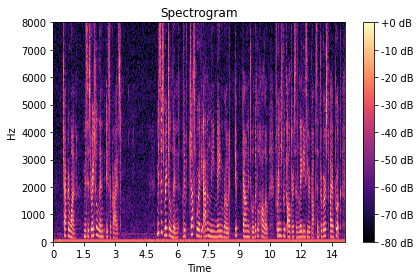

In [ ]:
#use example to make plot
draw_spectrogram("/content/drive/MyDrive/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")

In [ ]:
from librosa.feature import mfcc
from torchaudio.transforms import MFCC

sample_rate = 8000


librosa_mfcc = mfcc(audio_1, sr=sample_rate, n_mfcc=20, n_fft=2048, hop_length=512, power=2)

mfcc_module = MFCC(sample_rate=sr, n_mfcc=20, melkwargs={"n_fft": 2048, "hop_length": 512, "power": 2})
torch_mfcc = mfcc_module(torch.tensor(audio))

ParameterError: ignored

In [ ]:
## check example 
import numpy as np
TIMIT_sample= np.load("/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy")
TIMIT_sample

array([[[-5.783076 , -5.4550424, -4.4849415, ..., -3.8178372,
         -4.186981 , -4.0036488],
        [-5.993415 , -5.3618574, -4.4346747, ..., -3.4750547,
         -3.6915107, -3.7748134],
        [-5.989384 , -5.605701 , -4.6029243, ..., -3.1912458,
         -3.51342  , -3.5629208],
        ...,
        [-5.986337 , -5.2103047, -4.783456 , ..., -5.1597996,
         -5.7536016, -5.8234572],
        [-5.9906387, -5.1042953, -4.593709 , ..., -5.579624 ,
         -5.905373 , -5.897026 ],
        [-5.9922304, -5.0980163, -4.6106286, ..., -5.9161696,
         -5.968594 , -5.946773 ]],

       [[-5.6854367, -5.917743 , -5.5145793, ..., -5.8444624,
         -5.9379754, -5.722743 ],
        [-5.9418545, -5.96453  , -5.2898207, ..., -5.7666254,
         -5.856822 , -5.747618 ],
        [-5.9798365, -5.964807 , -5.1291866, ..., -5.510087 ,
         -5.544435 , -5.4631457],
        ...,
        [-5.994161 , -5.994068 , -5.9688444, ..., -5.837489 ,
         -5.9268045, -5.9378333],
        [-5.

In [ ]:
## change to tensor
t1=torch.from_numpy(TIMIT_sample)
t1

tensor([[[-5.7831, -5.4550, -4.4849,  ..., -3.8178, -4.1870, -4.0036],
         [-5.9934, -5.3619, -4.4347,  ..., -3.4751, -3.6915, -3.7748],
         [-5.9894, -5.6057, -4.6029,  ..., -3.1912, -3.5134, -3.5629],
         ...,
         [-5.9863, -5.2103, -4.7835,  ..., -5.1598, -5.7536, -5.8235],
         [-5.9906, -5.1043, -4.5937,  ..., -5.5796, -5.9054, -5.8970],
         [-5.9922, -5.0980, -4.6106,  ..., -5.9162, -5.9686, -5.9468]],

        [[-5.6854, -5.9177, -5.5146,  ..., -5.8445, -5.9380, -5.7227],
         [-5.9419, -5.9645, -5.2898,  ..., -5.7666, -5.8568, -5.7476],
         [-5.9798, -5.9648, -5.1292,  ..., -5.5101, -5.5444, -5.4631],
         ...,
         [-5.9942, -5.9941, -5.9688,  ..., -5.8375, -5.9268, -5.9378],
         [-5.9942, -5.9904, -5.9800,  ..., -5.8333, -5.8794, -5.9449],
         [-5.9925, -5.9847, -5.9888,  ..., -5.5298, -5.8002, -5.8842]],

        [[-5.3659, -5.2138, -5.1779,  ..., -3.2970, -3.3166, -3.2851],
         [-5.8404, -5.5970, -5.3171,  ..., -2

In [ ]:
t1.shape

torch.Size([8, 40, 180])

We get to know example tesor demension, it is 40*180 matrix with

and we can better used for later

### Computing the mfcc features

Now we come back to this librispeech dataset.

In [ ]:
# compute mfcc
mfcc = torchaudio.transforms.MFCC(n_mfcc=10, log_mels=True)(Sample1)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

NameError: ignored

In [ ]:
#torchaudio.transforms.FrequencyMasking()
#torchaudio.transforms.TimeMasking()

then

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

optimizer

In [ ]:
from torch import optim 

In [ ]:

## example from tutorial
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=hparams['learning_rate'],
	steps_per_epoch=int(len(train_loader)),
	epochs=hparams['epochs'],
	anneal_strategy='linear')

NameError: ignored

last step

In [ ]:
#libri_data = torchaudio.datasets.LIBRISPEECH('./', download=True)
#vctk_data = torchaudio.datasets.VCTK_092('./', download=True)

Then built based on the 


speaker features:
https://github.com/jameslyons/python_speech_features

https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/

In [ ]:
#GMM
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc

def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
              first =0
            else:
              first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feature = mfcc.mfcc(audio,rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

Authencation process

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


https://discuss.pytorch.org/t/how-to-save-model-weights-to-local-machine-from-colab/33318/2

save models

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode


## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html


#### pytorch method

In [ ]:

## based on computer vision product
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

NameError: ignored

# Data Preprocess

## Way of processing the audio

In [ ]:
#prepared paprameter and function for later usage
#librispeech
import glob
import os
import librosa
import numpy as np
# downloaded dataset path
audio_path = glob.glob(os.path.dirname('/content/drive/MyDrive/LibriSpeech/*/*/*/*.flac')) 
train_path = '/content/drive/MyDrive/LibriSpeech/train_tisv'
test_path  = '/content/drive/MyDrive/LibriSpeech/test_tisv'

In [ ]:
# for convenience ,define parameter for hp term
tisv_frame= 180
hop = 0.01
window =0.025 #s
#train_path_unprocessed= './TIMIT/TRAIN/*/*/*.wav'
train_path_unprocessed= '/content/drive/MyDrive/LibriSpeech/train-clean-100/*/*/*.wav'
#test_path_unprocessed: './TIMIT/TEST/*/*/*.wav'
test_path_unprocessed: '/content/drive/MyDrive/LibriSpeech/test-clean/*/*/*.wav'
nfft =512
nmels =40

In [ ]:
#copy timit to local colab

In [ ]:
# this is for convert data into numpy 

#----------------------------------------------


def save_spectrogram_tisv():
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set (VTCK)
    """
    print("start text independent utterance feature extraction")
    sr= 8000
    os.makedirs(train_path, exist_ok=True)   # make folder to save train file
    os.makedirs(test_path, exist_ok=True)    # make folder to save test file

    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.flac':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = torchaudio.load(utter_path, sr)        # load utterance audio
                intervals = torchaudio.effects.split(utter, top_db=10)         # voice activity detection 
                # this works fine for timit but if you get array of shape 0 for any other audio change value of top_db
                # for vctk dataset use top_db=100
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        print(utterances_spec.shape)
        if i<train_speaker_num:      # save spectrogram as numpy file
            np.save(os.path.join(train_path, "speaker%d.npy"%i), utterances_spec)
        else:
            np.save(os.path.join(test_path, "speaker%d.npy"%(i-train_speaker_num)), utterances_spec)


if __name__ == "__main__":
    save_spectrogram_tisv()

start text independent utterance feature extraction
total speaker number : 769
train : 684, test : 85
0th speaker processing...
(0,)
1th speaker processing...
(0,)
2th speaker processing...
(0,)
3th speaker processing...
(0,)
4th speaker processing...
(0,)
5th speaker processing...
(0,)
6th speaker processing...
(0,)
7th speaker processing...
(0,)
8th speaker processing...
(0,)
9th speaker processing...
(0,)
10th speaker processing...
(0,)
11th speaker processing...
(0,)
12th speaker processing...
(0,)
13th speaker processing...
(0,)
14th speaker processing...
(0,)
15th speaker processing...
(0,)
16th speaker processing...
(0,)
17th speaker processing...
(0,)
18th speaker processing...
(0,)
19th speaker processing...
(0,)
20th speaker processing...
(0,)
21th speaker processing...
(0,)
22th speaker processing...
(0,)
23th speaker processing...
(0,)
24th speaker processing...
(0,)
25th speaker processing...
(0,)
26th speaker processing...
(0,)
27th speaker processing...
(0,)
28th speaker

In [ ]:
## check example 
import numpy as np
Libri_sample= np.load("/content/drive/MyDrive/LibriSpeech/train_tisv/speaker0.npy")
Libri_sample

array([], dtype=float64)

In [ ]:
#prepared paprameter and function for later usage
import glob
import os
import librosa
import numpy as np
# downloaded dataset path
audio_path = glob.glob(os.path.dirname('/content/drive/MyDrive/TIMIT/*/*/*/*.wav')) 
train_path = './train_tisv'
test_path  = './test_tisv'

In [ ]:
# for convenience ,define parameter for hp term
tisv_frame= 180
hop = 0.01
window =0.025 #s
#train_path_unprocessed= './TIMIT/TRAIN/*/*/*.wav'
train_path_unprocessed= '/content/drive/MyDrive/TIMIT/TRAIN/*/*/*.wav'
#test_path_unprocessed: './TIMIT/TEST/*/*/*.wav'
test_path_unprocessed: '/content/drive/MyDrive/TIMIT/TEST/*/*/*.wav'
nfft =512
nmels =40

In [ ]:
#preprocess copy TIMIT
#%cp -av "/content/drive/MyDrive/TIMIT" "/content/"


In [ ]:
#tf config
class hyperparam:
    train_path = "train"
    test_path = "test"
    model_path = "model"
    
    # spectrogram params
    tisv_frame = 180 # max frame number of utterances of tdsv
    hop = 0.01 # hop size (s)
    window = 0.025 # window length (s)
    sr = 8000 # sampling rate
    
    # model params
    num_layer = 3 # number of lstm layers
    hidden = 128 # hidden state dimension of lstm
    proj = 64 # projection dimension of lstm
    
    # training params
    N = 4 # number of speakers of batch 
    M = 5 # number of utterances per speaker
    train = True
    optim = 'sgd' # optimizer type
    loss = 'softmax' # loss type (softmax or contrast)

    iteration = 10000
    lr = 1e-2
    
    # test params
    tdsv = False # text dependent or not
    model_num = 1 # number of ckpt file to load
    
config = hyperparam()

tf.test.gpu_device_name()

NameError: ignored

In [ ]:

#tf version
def save_spectrogram_tisv(audio_path, cutting = True, cutted = 30, cut_utter = 100):
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set (VTCK)
    """
    print("start text independent utterance feature extraction")
    os.makedirs(config.train_path, exist_ok=True)   # make folder to save train file
    os.makedirs(config.test_path, exist_ok=True)    # make folder to save test file

    total_speaker_num = len(os.listdir(audio_path))
    
    if cutting:
        train_speaker_num= (cutted//10)*8 # for cutting set
    else:
        train_speaker_num= (total_speaker_num//10)*9  # split total data 90% train and 10% test
    
    
    print("total speaker number : %d"%total_speaker_num)
    if cutting:
        print("train : %d, test : %d"%(train_speaker_num, cutted+1-train_speaker_num))
    else:
        print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    print(os.listdir(audio_path))
    
    for i, folder in enumerate(os.listdir(audio_path)):
        speaker_path = os.path.join(audio_path, folder)     # path of each speaker
        print("%d th speaker processing..." % i)
        utterances_spec = []
        k=0
        for j, utter_name in enumerate(os.listdir(speaker_path)):
            utter_path = os.path.join(speaker_path, utter_name)         # path of each utterance
            utter, sr = librosa.core.load(utter_path, config.sr)        # load utterance audio
            # trim the silence in the audio. the interval of utter_trim corresponding to the non-silent region
            utter_trim, index = librosa.effects.trim(utter, top_db=20)
            
            cur_slide = 0
            mfcc_win_sample = int(config.sr*config.hop*config.tisv_frame) # the length of a mfcc window
            while(True):
                if(cur_slide + mfcc_win_sample > utter_trim.shape[0]):
                    break
                slide_win = utter_trim[cur_slide : cur_slide+mfcc_win_sample]

                S = librosa.feature.mfcc(y=slide_win, sr=config.sr, n_mfcc=40)
                utterances_spec.append(S)
                cur_slide += int(mfcc_win_sample/2)
            if cutting:
                if j > cut_utter:
                    break
                
        utterances_spec = np.array(utterances_spec)
        print('utterances_spec.shape = {}'.format(utterances_spec.shape))

        if i<train_speaker_num:      # save spectrogram as numpy file
            np.save(os.path.join(config.train_path, "speaker%d.npy"%i), utterances_spec)
        else:
            np.save(os.path.join(config.test_path, "speaker%d.npy"%(i-train_speaker_num)), utterances_spec)
        
        if cutting:
            if i > cutted-1:
                break

In [ ]:
# this is for convert data into numpy 

#----------------------------------------------


#def save_spectrogram_tisv():
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set (VTCK)
    """
    print("start text independent utterance feature extraction")
    sr= 16000
    os.makedirs(train_path, exist_ok=True)   # make folder to save train file
    os.makedirs(test_path, exist_ok=True)    # make folder to save test file

    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.WAV':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = librosa.core.load(utter_path, sr)        # load utterance audio
                intervals = librosa.effects.split(utter, top_db=30)         # voice activity detection 
                # this works fine for timit but if you get array of shape 0 for any other audio change value of top_db
                # for vctk dataset use top_db=100
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        print(utterances_spec.shape)
        if i<train_speaker_num:      # save spectrogram as numpy file
            np.save(os.path.join(train_path, "speaker%d.npy"%i), utterances_spec)
        else:
            np.save(os.path.join(test_path, "speaker%d.npy"%(i-train_speaker_num)), utterances_spec)


if __name__ == "__main__":
    save_spectrogram_tisv()

start text independent utterance feature extraction
total speaker number : 630
train : 567, test : 63
0th speaker processing...
(12, 40, 180)
1th speaker processing...
(12, 40, 180)
2th speaker processing...
(18, 40, 180)
3th speaker processing...
(16, 40, 180)
4th speaker processing...
(20, 40, 180)
5th speaker processing...
(10, 40, 180)
6th speaker processing...
(8, 40, 180)
7th speaker processing...
(18, 40, 180)
8th speaker processing...
(14, 40, 180)
9th speaker processing...
(14, 40, 180)
10th speaker processing...
(16, 40, 180)
11th speaker processing...
(12, 40, 180)
12th speaker processing...
(16, 40, 180)
13th speaker processing...
(14, 40, 180)
14th speaker processing...
(18, 40, 180)
15th speaker processing...
(14, 40, 180)
16th speaker processing...
(8, 40, 180)
17th speaker processing...
(18, 40, 180)
18th speaker processing...
(12, 40, 180)
19th speaker processing...
(18, 40, 180)
20th speaker processing...
(8, 40, 180)
21th speaker processing...
(18, 40, 180)
22th spea

In [ ]:
#For convenience we copy term from gdrive

%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv" "/content/"
%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/test_tisv" "/content/"

'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv' -> '/content/train_tisv'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker112.npy' -> '/content/train_tisv/speaker112.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker127.npy' -> '/content/train_tisv/speaker127.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker130.npy' -> '/content/train_tisv/speaker130.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker117.npy' -> '/content/train_tisv/speaker117.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker131.npy' -> '/content/train_tisv/speaker131.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker129.npy' -> '/content/train_tisv/speaker129.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker124.npy' -> '/content/train_tisv/speaker124.npy'
'/content/driv

After this preprocess step, we now have the testing data and training data in the numpy form. 

"/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy" 

# Fresh Start 

Now it is the formal start. The baseline model is based on the Google paper of the speaker verification.
The baseline neural network structuure has the following property.

ref: 
The system used a 3-layer LSTM with projection. The embedding vector (d-vector) size is the same as the LSTM projection size. For TI-SV, we use 768 hidden nodes with projection size 256. When training the GE2E model, each batch
contains N = 64 speakers and M = 10 utterances per speaker.
We train the network with SGD using initial learning rate 0.01,
and decrease it by half every 30M steps. The L2-norm of gradient is
clipped at 3 , and the gradient scale for projection node in LSTM
is set to 0.5.


#Baseline-Using TIMIT dataset

Based and revised on the google paper. 


The code is mainly revised based on the https://github.com/Janghyun1230/Speaker_Verification tensorflow version. 

## Model Definition



Here I use the pytorch lighting model

## DataLoad

In [ ]:

from torch.utils.data import Dataset
# for pytorch implement
class SpeakerDataset(Dataset):   
    def __init__(self):

#------

        if training:
            self.path = train_path_unprocessed
            self.utterance_number =M
        else:
            self.path = test_path_unprocessed
            self.utterance_number = test_M
        self.speakers = glob.glob(os.path.dirname(self.path))
        shuffle(self.speakers)
        
    def __len__(self):
        return len(self.speakers)

    def __getitem__(self, idx):
        
        speaker = self.speakers[idx]
        wav_files = glob.glob(speaker+'/*.WAV')
        shuffle(wav_files)
        wav_files = wav_files[0:self.utterance_number]
        
        mel_dbs = []
        for f in wav_files:
            _, mel_db, _ = mfccs_and_spec(f, wav_process = True)
            mel_dbs.append(mel_db)
        return torch.Tensor(mel_dbs)

class SpeakerDatasetPreprocessed(Dataset):
    
    def __init__(self, shuffle=True, utter_start=0):
        
        # data path
        if training:
            self.path = train_path
            self.utter_num = M #train_M
        else:
            self.path = test_path
            self.utter_num = test_M
        self.file_list = os.listdir(self.path)
        self.shuffle=shuffle
        self.utter_start = utter_start
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        np_file_list = os.listdir(self.path)
        
        if self.shuffle:
            selected_file = random.sample(np_file_list, 1)[0]  # select random speaker
        else:
            selected_file = np_file_list[idx]               
        
        utters = np.load(os.path.join(self.path, selected_file))        # load utterance spectrogram of selected speaker
        if self.shuffle:
            utter_index = np.random.randint(0, utters.shape[0], self.utter_num)   # select M utterances per speaker
            utterance = utters[utter_index]       
        else:
            utterance = utters[self.utter_start: self.utter_start+self.utter_num] # utterances of a speaker [batch(M), n_mels, frames]

        utterance = utterance[:,:,:160]               # TODO implement variable length batch size

        utterance = torch.tensor(np.transpose(utterance, axes=(0,2,1)))     # transpose [batch, frames, n_mels]
        return utterance



In [ ]:
libri_train
libri_val
libri_test

In [ ]:
def prepare_data(self):
  ##prepare transform to dataset
  

## training

In [ ]:
#set to be trained mode
# true for training, otherwise testing
training = !!bool "true"


In [ ]:
train_path= './train_tisv'
train_path_unprocessed= '/content/drive/MyDrive/TIMIT/TRAIN/*/*/*.wav'

unprocessed_data= '/content/drive/MyDrive/TIMIT/*/*/*/*.wav'


In [ ]:
#some extra function for the model 
import torch.autograd as grad

def get_centroids_prior(embeddings):
    centroids = []
    for speaker in embeddings:
        centroid = 0
        for utterance in speaker:
            centroid = centroid + utterance
        centroid = centroid/len(speaker)
        centroids.append(centroid)
    centroids = torch.stack(centroids)
    return centroids

def get_centroids(embeddings):
    centroids = embeddings.mean(dim=1)
    return centroids

def get_centroid(embeddings, speaker_num, utterance_num):
    centroid = 0
    for utterance_id, utterance in enumerate(embeddings[speaker_num]):
        if utterance_id == utterance_num:
            continue
        centroid = centroid + utterance
    centroid = centroid/(len(embeddings[speaker_num])-1)
    return centroid

def get_utterance_centroids(embeddings):
    """
    Returns the centroids for each utterance of a speaker, where
    the utterance centroid is the speaker centroid without considering
    this utterance

    Shape of embeddings should be:
        (speaker_ct, utterance_per_speaker_ct, embedding_size)
    """
    sum_centroids = embeddings.sum(dim=1)
    # we want to subtract out each utterance, prior to calculating the
    # the utterance centroid
    sum_centroids = sum_centroids.reshape(
        sum_centroids.shape[0], 1, sum_centroids.shape[-1]
    )
    # we want the mean but not including the utterance itself, so -1
    num_utterances = embeddings.shape[1] - 1
    centroids = (sum_centroids - embeddings) / num_utterances
    return centroids

def get_cossim_prior(embeddings, centroids):
    # Calculates cosine similarity matrix. Requires (N, M, feature) input
    cossim = torch.zeros(embeddings.size(0),embeddings.size(1),centroids.size(0))
    for speaker_num, speaker in enumerate(embeddings):
        for utterance_num, utterance in enumerate(speaker):
            for centroid_num, centroid in enumerate(centroids):
                if speaker_num == centroid_num:
                    centroid = get_centroid(embeddings, speaker_num, utterance_num)
                output = F.cosine_similarity(utterance,centroid,dim=0)+1e-6
                cossim[speaker_num][utterance_num][centroid_num] = output
    return cossim

def get_cossim(embeddings, centroids):
    # number of utterances per speaker
    num_utterances = embeddings.shape[1]
    utterance_centroids = get_utterance_centroids(embeddings)

    # flatten the embeddings and utterance centroids to just utterance,
    # so we can do cosine similarity
    utterance_centroids_flat = utterance_centroids.view(
        utterance_centroids.shape[0] * utterance_centroids.shape[1],
        -1
    )
    embeddings_flat = embeddings.view(
        embeddings.shape[0] * num_utterances,
        -1
    )
    # the cosine distance between utterance and the associated centroids
    # for that utterance
    # this is each speaker's utterances against his own centroid, but each
    # comparison centroid has the current utterance removed
    cos_same = F.cosine_similarity(embeddings_flat, utterance_centroids_flat)

    # now we get the cosine distance between each utterance and the other speakers'
    # centroids
    # to do so requires comparing each utterance to each centroid. To keep the
    # operation fast, we vectorize by using matrices L (embeddings) and
    # R (centroids) where L has each utterance repeated sequentially for all
    # comparisons and R has the entire centroids frame repeated for each utterance
    centroids_expand = centroids.repeat((num_utterances * embeddings.shape[0], 1))
    embeddings_expand = embeddings_flat.unsqueeze(1).repeat(1, embeddings.shape[0], 1)
    embeddings_expand = embeddings_expand.view(
        embeddings_expand.shape[0] * embeddings_expand.shape[1],
        embeddings_expand.shape[-1]
    )
    cos_diff = F.cosine_similarity(embeddings_expand, centroids_expand)
    cos_diff = cos_diff.view(
        embeddings.size(0),
        num_utterances,
        centroids.size(0)
    )
    # assign the cosine distance for same speakers to the proper idx
    same_idx = list(range(embeddings.size(0)))
    cos_diff[same_idx, :, same_idx] = cos_same.view(embeddings.shape[0], num_utterances)
    cos_diff = cos_diff + 1e-6
    return cos_diff

def calc_loss_prior(sim_matrix):
    # Calculates loss from (N, M, K) similarity matrix
    per_embedding_loss = torch.zeros(sim_matrix.size(0), sim_matrix.size(1))
    for j in range(len(sim_matrix)):
        for i in range(sim_matrix.size(1)):
            per_embedding_loss[j][i] = -(sim_matrix[j][i][j] - ((torch.exp(sim_matrix[j][i]).sum()+1e-6).log_()))
    loss = per_embedding_loss.sum()    
    return loss, per_embedding_loss

def calc_loss(sim_matrix):
    same_idx = list(range(sim_matrix.size(0)))
    pos = sim_matrix[same_idx, :, same_idx]
    neg = (torch.exp(sim_matrix).sum(dim=2) + 1e-6).log_()
    per_embedding_loss = -1 * (pos - neg)
    loss = per_embedding_loss.sum()
    return loss, per_embedding_loss

def normalize_0_1(values, max_value, min_value):
    normalized = np.clip((values - min_value) / (max_value - min_value), 0, 1)
    return normalized

def mfccs_and_spec(wav_file, wav_process = False, calc_mfccs=False, calc_mag_db=False):    
    sound_file, _ = librosa.core.load(wav_file, sr=sr)
    window_length = int(window*sr)
    hop_length = int(hop*sr)
    duration = tisv_frame * hop + window
    
    # Cut silence and fix length
    if wav_process == True:
        sound_file, index = librosa.effects.trim(sound_file, frame_length=window_length, hop_length=hop_length)
        length = int(sr * duration)
        sound_file = librosa.util.fix_length(sound_file, length)
        
    spec = librosa.stft(sound_file, n_fft=nfft, hop_length=hop_length, win_length=window_length)
    mag_spec = np.abs(spec)
    
    mel_basis = librosa.filters.mel(sr, nfft, n_mels=nmels)
    mel_spec = np.dot(mel_basis, mag_spec)
    
    mag_db = librosa.amplitude_to_db(mag_spec)
    #db mel spectrogram
    mel_db = librosa.amplitude_to_db(mel_spec).T
    
    mfccs = None
    if calc_mfccs:
        mfccs = np.dot(librosa.filters.dct(40, mel_db.shape[0]), mel_db).T
    
    return mfccs, mel_db, mag_db

if __name__ == "__main__":
    w = grad.Variable(torch.tensor(1.0))
    b = grad.Variable(torch.tensor(0.0))
    embeddings = torch.tensor([[0,1,0],[0,0,1], [0,1,0], [0,1,0], [1,0,0], [1,0,0]]).to(torch.float).reshape(3,2,3)
    centroids = get_centroids(embeddings)
    cossim = get_cossim(embeddings, centroids)
    sim_matrix = w*cossim + b
    loss, per_embedding_loss = calc_loss(sim_matrix)

This is for speech embedding

In [ ]:
#speach embedder pytorch
class SpeechEmbedder(nn.Module):
    
    def __init__(self):
      # super avoid call the 
        nmels =40 #Number of mel energies
        hidden= 768 #Number of LSTM hidden layer units
        proj=256 #Embedding size
        num_layer=3
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(nmels, hidden, num_layers=num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            #Fills the input Tensor with values according to the method 
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hidden, proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

## using Generalized end to end loss function. 
class GE2ELoss(nn.Module):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0).to(device), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(-5.0).to(device), requires_grad=True)
        self.device = device
    
    def forward(self, embeddings):
        torch.clamp(self.w, 1e-6)
        centroids = get_centroids(embeddings)
        cossim = get_cossim(embeddings, centroids)
        sim_matrix = self.w*cossim.to(self.device) + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss


In [ ]:
#parameter for trainning

N=4 #Number of speakers in batch
M=5 #Number of utterances per speaker

num_workers= 2 #number of workers for dataloader
lr=0.01 
epochs= 950 #Max training speaker epoch 
#log_file='./speech_id_checkpoint/Stats' #save on google drive
log_file='/content/drive/MyDrive/Pytorchmodel/speech_id_checkpoint/Stats' #save on google drive

log_interval= 30 #Epochs before printing progress
checkpoint_interval= 120 #Save model after x speaker epochs
#checkpoint_dir= './speech_id_checkpoint'
checkpoint_dir= '/content/drive/MyDrive/Pytorchmodel/speech_id_checkpoint'
restore= !!bool "true" #Resume training from previous model path

#point for starting 
data_preprocessed= !!bool "true"

then

In [ ]:
#parameter for test

test_M= 6
test_N= 4 #Number of utterances per speaker


test_path_unprocessed='/content/drive/MyDrive/TIMIT/TEST/*/*/*.wav'
test_path ='./test_tisv'
test_epochs =10

In [ ]:
from torch.utils.data import DataLoader
#trainning the
def train(model_path):
    data_preprocessed= !!bool "false"#determine
    device = torch.device("cuda") #use cuda
    if data_preprocessed: #data preprecessed
        train_dataset = SpeakerDatasetPreprocessed()
    else:
        train_dataset = SpeakerDataset()
    train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True, num_workers=num_workers, drop_last=True) 
    
    embedder_net = SpeechEmbedder().to(device)
    if restore:
        embedder_net.load_state_dict(torch.load(model_path))
    ge2e_loss = GE2ELoss(device)
    #Both net and loss have trainable parameters
    optimizer = torch.optim.SGD([
                    {'params': embedder_net.parameters()},
                    {'params': ge2e_loss.parameters()}
                ], lr=lr)
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    embedder_net.train()
    iteration = 0
    for e in range(epochs):
        total_loss = 0
        for batch_id, mel_db_batch in enumerate(train_loader): 
            mel_db_batch = mel_db_batch.to(device)
            
            mel_db_batch = torch.reshape(mel_db_batch, (N*M, mel_db_batch.size(2), mel_db_batch.size(3)))
            perm = random.sample(range(0, N*M), N*M)
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
            mel_db_batch = mel_db_batch[perm]
            #gradient accumulates
            optimizer.zero_grad()
            
            embeddings = embedder_net(mel_db_batch)
            embeddings = embeddings[unperm]
            embeddings = torch.reshape(embeddings, (N, M, embeddings.size(1)))
            
            #get loss, call backward, step optimizer
            loss = ge2e_loss(embeddings) #wants (Speaker, Utterances, embedding)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(embedder_net.parameters(), 3.0)
            torch.nn.utils.clip_grad_norm_(ge2e_loss.parameters(), 1.0)
            optimizer.step()
            
            total_loss = total_loss + loss
            iteration += 1
            if (batch_id + 1) % log_interval == 0:
                mesg = "{0}\tEpoch:{1}[{2}/{3}],Iteration:{4}\tLoss:{5:.4f}\tTLoss:{6:.4f}\t\n".format(time.ctime(), e+1,
                        batch_id+1, len(train_dataset)//N, iteration,loss, total_loss / (batch_id + 1))
                print(mesg)
                if log_file is not None:
                    with open(log_file,'a') as f:
                        f.write(mesg)
                    
        if checkpoint_dir is not None and (e + 1) % checkpoint_interval == 0:
            embedder_net.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e+1) + "_batch_id_" + str(batch_id+1) + ".pth"
            ckpt_model_path = os.path.join(checkpoint_dir, ckpt_model_filename)
            torch.save(embedder_net.state_dict(), ckpt_model_path)
            embedder_net.to(device).train()

    #save model
    embedder_net.eval().cpu()
    save_model_filename = "final_epoch_" + str(e + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
    save_model_path = os.path.join(checkpoint_dir, save_model_filename)
    torch.save(embedder_net.state_dict(), save_model_path)
    print("\nDone, trained model saved at", save_model_path)




In [ ]:
import random
import time
import numpy as np

In [ ]:
#save on google drive
model_path= '/content/drive/MyDrive/Pytorchmodel/model.model'

In [ ]:
def test(model_path):
    #save on google drive
    if data_preprocessed:
        test_dataset = SpeakerDatasetPreprocessed()
    else:
        test_dataset = SpeakerDataset()
    test_loader = DataLoader(test_dataset, batch_size=test_N, shuffle=True, num_workers=test_num_workers, drop_last=True)
    embedder_net = SpeechEmbedder()
    embedder_net.load_state_dict(torch.load(model_path))
    embedder_net.eval()
    
    avg_EER = 0
    for e in range(test_epochs):
        batch_avg_EER = 0
        model_path= '/content/drive/MyDrive/Pytorchmodel/model.model'

        for batch_id, mel_db_batch in enumerate(test_loader):
            assert test_M % 2 == 0
            enrollment_batch, verification_batch = torch.split(mel_db_batch, int(mel_db_batch.size(1)/2), dim=1)
            enrollment_batch = torch.reshape(enrollment_batch, (test_N*test_M//2, enrollment_batch.size(2), enrollment_batch.size(3)))
            verification_batch = torch.reshape(verification_batch, (test_N*test_M//2, verification_batch.size(2), verification_batch.size(3)))
            
            perm = random.sample(range(0,verification_batch.size(0)), verification_batch.size(0))
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
                
            verification_batch = verification_batch[perm]
            enrollment_embeddings = embedder_net(enrollment_batch)
            verification_embeddings = embedder_net(verification_batch)
            verification_embeddings = verification_embeddings[unperm]
            
            enrollment_embeddings = torch.reshape(enrollment_embeddings, (test_N, test_M//2, enrollment_embeddings.size(1)))
            verification_embeddings = torch.reshape(verification_embeddings, (test_N, test_M//2, verification_embeddings.size(1)))
            
            enrollment_centroids = get_centroids(enrollment_embeddings)
            
            sim_matrix = get_cossim(verification_embeddings, enrollment_centroids)
            
            # calculating EER
            diff = 1; EER=0; EER_thresh = 0; EER_FAR=0; EER_FRR=0
            
            for thres in [0.01*i+0.5 for i in range(50)]:
                sim_matrix_thresh = sim_matrix>thres
                
                FAR = (sum([sim_matrix_thresh[i].float().sum()-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(test_N))])
                /(test_N-1.0)/(float(test_M/2))/test_N)
    
                FRR = (sum([test_M/2-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(test_N))])
                /(float(test_M/2))/test_N)
                
                # Save threshold when FAR = FRR (=EER)
                if diff> abs(FAR-FRR):
                    diff = abs(FAR-FRR)
                    EER = (FAR+FRR)/2
                    EER_thresh = thres
                    EER_FAR = FAR
                    EER_FRR = FRR
            batch_avg_EER += EER
            print("\nEER : %0.2f (thres:%0.2f, FAR:%0.2f, FRR:%0.2f)"%(EER,EER_thresh,EER_FAR,EER_FRR))
            avg_EER += batch_avg_EER/(batch_id+1)
            avg_EER = avg_EER / test_epochs
            print("\n EER across {0} epochs: {1:.4f}".format(test_epochs, avg_EER))
        
if __name__=="__main__":
    if training:
        train(model_path)
    else:
        test(model_path)

Streaming output truncated to the last 5000 lines.
Wed Dec 16 07:36:56 2020	Epoch:61[120/141],Iteration:8580	Loss:0.0464	TLoss:0.4772	

Wed Dec 16 07:37:00 2020	Epoch:62[30/141],Iteration:8631	Loss:0.0625	TLoss:0.7612	

Wed Dec 16 07:37:02 2020	Epoch:62[60/141],Iteration:8661	Loss:0.0138	TLoss:0.7962	

Wed Dec 16 07:37:04 2020	Epoch:62[90/141],Iteration:8691	Loss:0.6311	TLoss:0.7494	

Wed Dec 16 07:37:06 2020	Epoch:62[120/141],Iteration:8721	Loss:0.1503	TLoss:0.6638	

Wed Dec 16 07:37:10 2020	Epoch:63[30/141],Iteration:8772	Loss:0.0169	TLoss:0.3133	

Wed Dec 16 07:37:12 2020	Epoch:63[60/141],Iteration:8802	Loss:0.2411	TLoss:0.3345	

Wed Dec 16 07:37:14 2020	Epoch:63[90/141],Iteration:8832	Loss:0.7050	TLoss:0.4383	

Wed Dec 16 07:37:16 2020	Epoch:63[120/141],Iteration:8862	Loss:2.4150	TLoss:0.4987	

Wed Dec 16 07:37:19 2020	Epoch:64[30/141],Iteration:8913	Loss:0.0087	TLoss:0.6537	

Wed Dec 16 07:37:22 2020	Epoch:64[60/141],Iteration:8943	Loss:0.1423	TLoss:0.6907	

Wed Dec 16 07:37:24 20

#### Training with a single batch

In [ ]:
network= Network()

train_loader = torch.utils.data.DataLoader(train_srt,batch size= 100)

optimizer = optim.Adam(network.parameters(),lr=0.01 )



SyntaxError: ignored

code

In [ ]:
# defining global variable path
# Location of my dataset on My Google Drive
file_path = "/content/drive/MyDrive/TIMIT/TRAIN"
import tensorflow as tf

def loadFiles(path):
    '''Put files into lists and return them as one list with all files 
     in the folder'''
    wav_files = sorted([os.path.join(path, 'train', file)
                          for file in os.listdir(path + "/train")
                          if file.endswith('.wav')])
    return file_path


NameError: ignored

In [ ]:
### example 
'''
learning_rate = 5e-4
batch_size = 10
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set, experiment)

'''

For convenience we create the class for that

In [ ]:
#model is revised based on the code by https://github.com/HarryVolek/PyTorch_Speaker_Verification/blob/master/data_load.py

class SpeakerDataset_flac(Dataset):
    
    def __init__(self):

        if hp.training:
            self.path = hp.data.train_path_unprocessed
            self.utterance_number = hp.train.M
        else:
            self.path = hp.data.test_path_unprocessed
            self.utterance_number = hp.test.M
        self.speakers = glob.glob(os.path.dirname(self.path))
        shuffle(self.speakers)
        
    def __len__(self):
        return len(self.speakers)

    def __getitem__(self, idx):
        
        speaker = self.speakers[idx]
        wav_files = glob.glob(speaker+'/*.WAV')
        shuffle(wav_files)
        wav_files = wav_files[0:self.utterance_number]
        
        mel_dbs = []
        for f in wav_files:
            _, mel_db, _ = mfccs_and_spec(f, wav_process = True)
            mel_dbs.append(mel_db)
        return torch.Tensor(mel_dbs)

class SpeakerDatasetPreprocessed(Dataset):
    
    def __init__(self, shuffle=True, utter_start=0):
        
        # data path
        if hp.training:
            self.path = hp.data.train_path
            self.utter_num = hp.train.M
        else:
            self.path = hp.data.test_path
            self.utter_num = hp.test.M
        self.file_list = os.listdir(self.path)
        self.shuffle=shuffle
        self.utter_start = utter_start
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        np_file_list = os.listdir(self.path)
        
        if self.shuffle:
            selected_file = random.sample(np_file_list, 1)[0]  # select random speaker
        else:
            selected_file = np_file_list[idx]               
        
        utters = np.load(os.path.join(self.path, selected_file))        # load utterance spectrogram of selected speaker
        if self.shuffle:
            utter_index = np.random.randint(0, utters.shape[0], self.utter_num)   # select M utterances per speaker
            utterance = utters[utter_index]       
        else:
            utterance = utters[self.utter_start: self.utter_start+self.utter_num] # utterances of a speaker [batch(M), n_mels, frames]

        utterance = utterance[:,:,:160]               # TODO implement variable length batch size

        utterance = torch.tensor(np.transpose(utterance, axes=(0,2,1)))     # transpose [batch, frames, n_mels]
        return utterance


## saving model

check: https://pytorch-lightning.readthedocs.io/en/stable/weights_loading.html

In [ ]:
# saves checkpoints to '/your/path/to/save/checkpoints' at every epoch end
trainer = Trainer(default_root_dir='/your/path/to/save/checkpoints')

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

class LitAutoEncoder(pl.LightningModule):
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)

        # 1. calculate loss
        loss = F.cross_entropy(y_hat, y)

        # 2. log `val_loss`
        self.log('val_loss', loss)

# 3. Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback = ModelCheckpoint(monitor='val_loss')

# 4. Add your callback to the callbacks list
trainer = Trainer(callbacks=[checkpoint_callback])

# Performance Check

Based on the result, we now have that 

### Tensorboard

I used the TensorBoard to use visualization for experimental 

In [ ]:
print(torch.__version__)

In [ ]:
train_model(10)
writer.flush()

In [ ]:
!tensorboard --logdir=runs

In [ ]:
!pip install tensorboard --upgrade

     |████████████████████████████████| 10.6MB 8.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0


In [ ]:
#upload and share
!tensorboard dev upload --logdir runs \
--name "My latest experiment" \
--description "Simple comparison of several hyperparameters"

# Tuning the answer

In [ ]:
for name, param in network.named_parameters():
  print(name, '\')

Plan to use a goodgle dataset

In [ ]:
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls

# Final Result:



Here I got the result of EER of 

Based on my result, the EER I got is about 

### Single prediction

To test how well system go, I also add single file tester:


https://github.com/Aurora11111/speaker-recognition-pytorch/blob/master/singlepredict.py



add recording part

In [ ]:
# import library for record
from dl_colab_notebooks.audio import record_audio, upload_audio

In [ ]:
SAMPLE_RATE = 16000
record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

def _recognize(audio):
  display(Audio(audio, rate=SAMPLE_RATE, autoplay=True))
  wavfile.write('test.wav', SAMPLE_RATE, (32767*audio).astype(np.int16))

  audio = Compose([LoadAudio(), ComputeMelSpectrogram(), ResizeMelSpectrogram()])({'fname': 'test.wav', 'text':''})['input']
  torch.set_grad_enabled(False)
  inputs = torch.from_numpy(audio).unsqueeze(0)
  inputs = inputs.permute(0, 2, 1).cuda()
  outputs = model(inputs)
  outputs = outputs.softmax(2).permute(1, 0, 2)
  greedy_decoder = GreedyDecoder(labels=vocab)
  decoded_output, _ = greedy_decoder.decode(outputs)
  print("\nwithout LM:")
  print(decoded_output[0][0])
  print("\n")

  ALPHA = 0.3  # How much do you trust for LM? 0 means don't use LM, bigger values more trust in LM
  BETA = 1.85  # not so important, using DeepSpeech default one
  beam_ctc_decoder = BeamCTCDecoder(labels='$' + vocab[1:].upper(), num_processes=4,
                                            lm_path=lm_model,
                                            alpha=ALPHA, beta=BETA,
                                            cutoff_top_n=40, cutoff_prob=1.0, beam_width=1000)
  decoded_output, _ = beam_ctc_decoder.decode(outputs)
  print("with LM:")
  print(decoded_output[0][0].lower())


def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  _recognize(audio)
def _upload_audio(b):
  clear_output()
  audio = upload_audio(sample_rate=SAMPLE_RATE)
  _recognize(audio)

if record_or_upload == "Record":
  button = widgets.Button(description="Record Speech")
  button.on_click(_record_audio)
  display(button)
else:
  try:
    _upload_audio("")
  except TypeError:
    print("uploading failed")

NameError: ignored

# Reference

1. https://github.com/mystlee/rasta_py/blob/master/rasta.py 

2. 